## Foreground extraction

In this worksheet, you will implement the second step of feature extraction: extracting the foreground of the images.

In [150]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

code_dir = './code'
from sys import path; path.append(code_dir); 
from utilities import *
from my_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exercise: images as numpy arrays
Remember from homework 1 that it is convenient to convert images to `numpy` arrays to do arithmetic, statistics, etc.
1. Load the first banana image, crop it, and store it in the variable `img`. Then convert it into a `numpy` array `M`:

In [151]:
### BEGIN SOLUTION
img = crop_image(Image.open("mini-dataset/b01.png"))
M = np.array(img)
### END SOLUTION

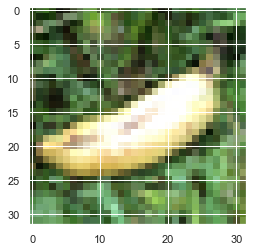

In [152]:
plt.imshow(M)

2.  Set `height`, `width`, and `nchannels` as the height, width,  and number of channels of the image.<br>
    Hint: use the shape of `M`, and recall the `a,b = (1,2)` trick.

In [178]:
### BEGIN SOLUTION
height, width, nchannels = M.shape
### END SOLUTION
height, width, nchannels

(32, 32, 3)

In [154]:
### BEGIN HIDDEN TESTS
assert height == 32
assert width == 32
assert nchannels == 3
### END HIDDEN TESTS

Check that the dimensions are consistent with `height` and `width`. You will notice that there are only 3 channels this time! Do you remember what those channels are?

## Exercise: Extract average foreground and background colors
As a step toward separating the foreground and the background of the **cropped** image, you will now the extract average colors thereof.
1. Assign to variables `fg_r`, `fg_g`, and `fg_b` the average (`mean`) of the channel values of the pixels in a square of size 10x10 centered in the middle of the image. Print `fg_r`, `fg_g`, and `fg_b`.<br>
    Hint: compute the mean over rows and columns.

In [174]:
### BEGIN SOLUTION
center = M[11:21, 12:22]
fg_r, fg_g, fg_b =  np.mean(np.mean(center, axis=1), axis=0)
### END SOLUTION
fg_r, fg_g, fg_b

(214.81, 211.45, 186.06)

TODO: l'extraction exacte n'est pas bien définie; trouver un bon test; peut-être un test visuel est suffisant.

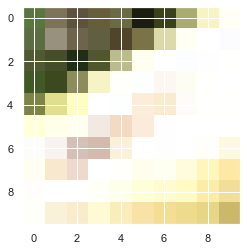

In [175]:
plt.imshow(center)

In [166]:
fg_r, fg_g, fg_b

(206.45, 204.59999999999997, 178.03)

In [163]:
assert abs(fg_r - 180) < 0.5
assert abs(fg_g - 182) < 0.5
assert abs(fg_b - 154) < 0.5

AssertionError: 

2. Assign to variables `bg_r`, `bg_g`, and `bg_b` the average of the channel values of the pixels in a square of size 10x10 located in the upper left corner of the image.

In [26]:
### BEGIN SOLUTION
bg_r, bg_g, bg_b =  np.mean(np.mean(M[0:10, 0:10], axis=1), axis=0)
### END SOLUTION
bg_r, bg_g, bg_b

(69.72, 94.53999999999999, 52.730000000000004)

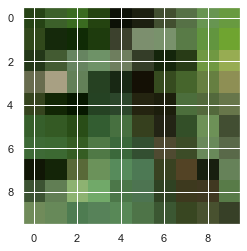

In [176]:
plt.imshow(M[0:10, 0:10])

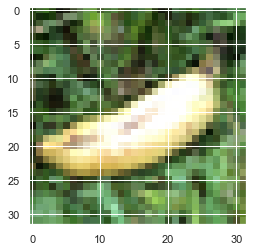

In [177]:
plt.imshow(M)

In [28]:
assert abs(bg_r - 70) < 0.5
assert abs(bg_g - 95) < 0.5
assert abs(bg_b - 53) < 0.5

3. Do the color codes make sense to you? That is do they match your perception? Create two small images `BG` and `FG` of uniform colors using the average colors you just extracted and display them side by side.<br>
    **Hint**: use `np.tile`.

In [50]:
### BEGIN SOLUTION
FG = np.tile([int(fg_r), int(fg_g), int(fg_b)], (32, 32, 1))
BG = np.tile([int(bg_r), int(bg_g), int(bg_b)], (32, 32, 1))
### END SOLUTION

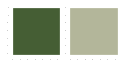

In [49]:
show_images([BG, FG])

### Exercise: extraction of color channels and of the foreground
1. Define three arrays of type `float` named `R`, `G`, and `B`, containing the red, green and blue channels respectively (for all pixels). Then define an array `D` (color difference) containing `R-(G+B)/2` and an array `V` (value of intensity) containing `(R+G+B)/3`.<br>
    **Hints**:
    - See last week's worksheets
    - Remember to convert values to float (for instance by multiplying the arrays by 1.); otherwise, arithmetic will be computed modulo 256.

In [73]:
### BEGIN SOLUTION
R = M[:,:,0] * 1.0
G = M[:,:,1] * 1.0
B = M[:,:,2] * 1.0
D = R-(G+B) / 2
V = (R+G+B) / 3
### END SOLUTION

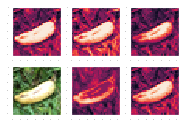

In [75]:
### BEGIN HIDDEN TESTS
assert R.shape == M.shape[0:2]
assert G.shape == M.shape[0:2]
assert B.shape == M.shape[0:2]

assert (V == (R+G+B) / 3).all()
assert (D == (R-(G+B) / 2)).all()
### END HIDDEN TESTS
show_images([R, G, B, M, D, V], columns=3)

Let's automatize the above process to apply it to any image
2. **Difference filter**. Complete the code of the following function:

In [77]:
def difference_filter(img):
    '''Extract a numpy array D = R-(G+B)/2 from the PIL image `img`.'''
    ### BEGIN SOLUTION
    M = np.array(img)
    R = M[:,:,0] * 1.0
    G = M[:,:,1] * 1.0
    B = M[:,:,2] * 1.0
    D = R-(G+B)/2
    ### END SOLUTION
    return D

Let's apply this filter to all our images:

In [80]:
data_dir = './mini-dataset'
a_images = get_images(data_dir, 'a*.png')
b_images = get_images(data_dir, 'b*.png')
images = a_images + b_images
cropped_images = [crop_image(img) for img in images]

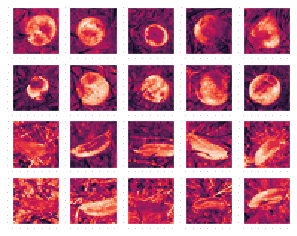

In [81]:
show_images([difference_filter(img) for img in cropped_images])

3. **Value filter**. Implement similarly a filter for the intensity `V`, and apply it to all images

In [85]:
def value_filter(img):
    '''Extract a numpy array V = (R+G+B)/3 from a PIL image `img`.'''
    ### BEGIN SOLUTION
    M = np.array(img)
    R = M[:,:,0] * 1.0
    G = M[:,:,1] * 1.0
    B = M[:,:,2] * 1.0
    V = (R+G+B)/3
    ### END SOLUTION
    return V

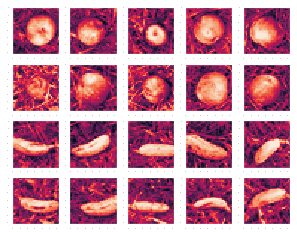

In [86]:
### BEGIN SOLUTION
show_images([value_filter(img) for img in cropped_images])
### END SOLUTION

4. **Foreground filter**. Create a foreground filter returning an array `F` (foreground) which has value `True` for most foreground pixels and value `False` for most background pixels.<br>
   **Hint**: Which of `D` or `V` is more contrasted to separate foreground from background in the apple or banana images? Take the pixel-wise `maximum` between `D` and `V` and call it `F0`. Then define a `threshold` as the middle point between the minimum and the maximum value of `F0`. Then `F` values are `True` if `F0` exceeds the `threshold`. You can ignore the parameter `theta`, or let the user customize the threshold with it. Other methods or ideas are possible.

In [83]:
def foreground_filter(img, theta = 2/3):
    '''Extract a numpy array with True as foreground 
    and False as background from a PIL image.
    Parameter theta is a relative binarization threshold.'''
    ### BEGIN SOLUTION
    D = difference_filter(img)
    V = value_filter(img) 
    F0 = np.maximum(D, V)
    threshold = theta*(np.max(F0) - np.min(F0))
    F = F0 > threshold
    ### END SOLUTION
    return F

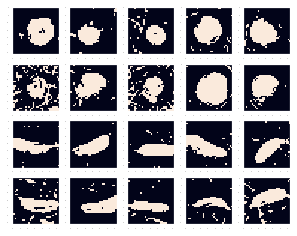

In [87]:
show_images([foreground_filter(img) for img in cropped_images])

5. **Transparent background filter**. Create a filter that replaces the background of a PIL image by a transparent background, and returns it as a new PIL image.<br>
    **Hints**:
    - You can insert a couple cells below for experimenting (`Insert` -> `Insert cell below`).
    - Start with our example image `img`. Reconstruct the orginal image from its `R`, `G` `B` channels by using `np.stack`, then `np.array(..., dtype='uint8')` to convert the values back to small integers, and then `Image.fromarray`. Check visually the result.
    - Redo the same with the additional transparency layer `T` given by `foreground_filter`. Note that the `False`,`True` values need to be converted to integers `0`, `255`. Check visually the result.
    - Repackage everything in the function `transparent_background_filter` below.

In [148]:
def transparent_background_filter(img, theta = 2/3):
    '''Return the PIL image `img` with its background set to transparent.'''
    ### BEGIN SOLUTION
    M = np.array(img)
    R = M[:,:,0]
    G = M[:,:,1]
    B = M[:,:,2]
    T = foreground_filter(img) * 255
    return Image.fromarray(np.array(np.stack([R,G,B,T], axis=2), dtype='uint8')) 
    ### END SOLUTION

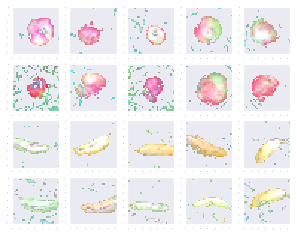

In [149]:
show_images([transparent_background_filter(img) for img in cropped_images])

Insert all the functions you have implemented above in `code/my_utilities.py`.